In [1]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
import os

c:\vsc\research\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.9


In [3]:
file_path = 'DB for chromophore_Sci_Data_rev02.csv'

df = pd.read_csv(file_path)

df = df[df["Quantum yield"].notna() & df["Chromophore"].notna() & df["Solvent"].notna()]
df = df[["Chromophore", "Solvent", "Quantum yield"]]
df = df[df["Quantum yield"] >= 0.1]  # take quantum yields bigger than 0.01
print("Filtered dataset size:", len(df))
# Optional extra dataset with SMILES / solvent / PLQY
extra_path = 'dataset2.xlsx'
if os.path.exists(extra_path):
    df_extra_raw = pd.read_excel(extra_path)
    cols_lower = {c.lower().strip(): c for c in df_extra_raw.columns}

    def pick(col_candidates):
        for name in col_candidates:
            if name.lower() in cols_lower:
                return cols_lower[name.lower()]
        return None

    chrom_col = pick(["chromophore", "smiles"])
    solv_col  = pick(["solvent"])
    qy_col    = pick(["quantum yield", "plqy", "plq y", "qy"])

    if chrom_col and solv_col and qy_col:
        df_extra = df_extra_raw[[chrom_col, solv_col, qy_col]].rename(
            columns={chrom_col: "Chromophore", solv_col: "Solvent", qy_col: "Quantum yield"}
        )
        df_extra = df_extra[df_extra["Quantum yield"].notna()
                            & df_extra["Chromophore"].notna()
                            & df_extra["Solvent"].notna()]
        df_extra = df_extra[df_extra["Quantum yield"] >= 0.1]
        print("Extra dataset usable rows:", len(df_extra))

        # Concatenate base and extra datasets
        df = pd.concat([df, df_extra], ignore_index=True)
    else:
        print("dataset2.xlsx found but required columns (SMILES/chromophore, solvent, PLQY/Quantum yield) not detected; using only base CSV.")
else:
    print("Extra dataset 'dataset2.xlsx' not found; using only base CSV.")

print("Total combined filtered dataset size:", len(df))
df.head()

Filtered dataset size: 9519
Extra dataset usable rows: 2188
Total combined filtered dataset size: 11707


,Chromophore,Solvent,Quantum yield
0,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.95
1,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.00
2,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.20
3,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,CO,0.60
4,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,CCO,0.69


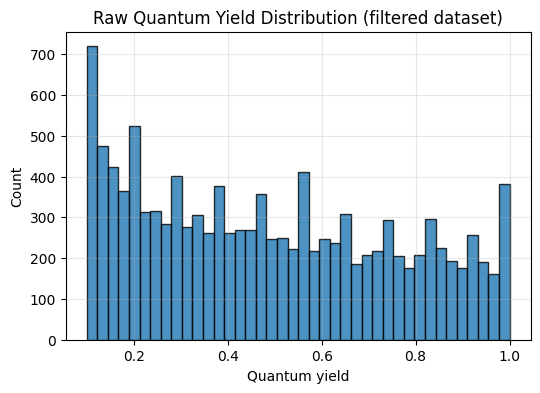

In [4]:
# Histogram of raw quantum yield distribution
plt.figure(figsize=(6,4))
plt.hist(df["Quantum yield"], bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield")
plt.ylabel("Count")
plt.title("Raw Quantum Yield Distribution (filtered dataset)")
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [6]:
import torch

CACHE_FILE = "embedding_cache.pt"

def load_cache():
    if os.path.exists(CACHE_FILE):
        return torch.load(CACHE_FILE)
    else:
        return {}  # empty cache

def save_cache(cache):
    torch.save(cache, CACHE_FILE)

In [7]:
def get_embeddings(smiles_list, batch_size=32, max_length=202):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cache = load_cache()
    all_embeddings = []


    to_compute = [s for s in smiles_list if s not in cache]

    if len(to_compute) > 0:
        print(f"Computing {len(to_compute)} new embeddings on {device}...")


        model.to(device)
        model.eval()

        with torch.no_grad():
            for i in range(0, len(to_compute), batch_size):
                batch = to_compute[i:i+batch_size]

                inputs = tokenizer(
                    batch, padding=True, truncation=True,
                    max_length=max_length, return_tensors="pt"
                ).to(device)


                outputs = model(**inputs)
                embeddings = outputs.pooler_output 


                for s, emb in zip(batch, embeddings):
                    cache[s] = emb.cpu()


        save_cache(cache)

    else:
        print("All embeddings already in cache.")


    ordered = [cache[s] for s in smiles_list]
    return torch.stack(ordered)


In [8]:
chrom_emb = get_embeddings(df["Chromophore"].tolist())
print("Chromophore embeddings shape:", chrom_emb.shape)

solv_emb = get_embeddings(df["Solvent"].tolist())
print("Solvent embeddings shape:", solv_emb.shape)

combined_emb = torch.cat([chrom_emb, solv_emb], dim=1)
print("Combined embedding shape:", combined_emb.shape)

All embeddings already in cache.
Chromophore embeddings shape: torch.Size([11707, 768])
All embeddings already in cache.
Solvent embeddings shape: torch.Size([11707, 768])
Combined embedding shape: torch.Size([11707, 1536])


In [9]:
# CRITICAL FIX: DO NOT SCALE HERE - This causes data leakage!
# Scaling should happen AFTER train/test split using only training data statistics
# This cell now only prepares the raw embeddings and target variable

# Combine raw embeddings (will be scaled later after splitting)
combined_emb = torch.cat([chrom_emb, solv_emb], dim=1)
y = torch.tensor(df["Quantum yield"].values, dtype=torch.float32).unsqueeze(1)

print("Raw combined embedding shape:", combined_emb.shape)
print("Target shape:", y.shape)

Raw combined embedding shape: torch.Size([11707, 1536])
Target shape: torch.Size([11707, 1])


In [10]:
# Prepare numpy features/targets and split BEFORE scaling (prevents data leakage)
import numpy as np
from sklearn.model_selection import train_test_split

# combined_emb may be torch.Tensor; convert to numpy
if 'combined_emb' in globals():
    X = combined_emb.numpy() if hasattr(combined_emb, 'numpy') else np.array(combined_emb)
else:
    raise RuntimeError('combined_emb not found. Run the embedding cells first.')

# y may be torch tensor of shape [N,1]
if 'y' in globals():
    if hasattr(y, 'numpy'):
        y_np = y.squeeze(1).numpy()
    else:
        y_np = np.array(y).squeeze()
else:
    raise RuntimeError('y (targets) not found. Run earlier cells that set y.')

# IMPORTANT: Split FIRST before any scaling/preprocessing (prevents data leakage)
# Create train/validation/test split (60% train, 20% validation, 20% test)
# First split: 60% train, 40% temp (which will be split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_np, test_size=0.40, random_state=42)

# Second split: split temp into 50/50 to get 20% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(f"X shape: {X.shape}, y shape: {y_np.shape}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X shape: (11707, 1536), y shape: (11707,)
X_train: (7024, 1536), y_train: (7024,)
X_val: (2341, 1536), y_val: (2341,)
X_test: (2342, 1536), y_test: (2342,)


In [11]:
# Scale embeddings using ONLY training data statistics (prevents data leakage)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Split embeddings back into chromophore and solvent parts for separate scaling
n_chrom_features = chrom_emb.shape[1]  # 768
n_solv_features = solv_emb.shape[1]    # 768

# Split train/val/test sets into chromophore and solvent parts
X_train_chrom = X_train[:, :n_chrom_features]
X_train_solv = X_train[:, n_chrom_features:]
X_val_chrom = X_val[:, :n_chrom_features]
X_val_solv = X_val[:, n_chrom_features:]
X_test_chrom = X_test[:, :n_chrom_features]
X_test_solv = X_test[:, n_chrom_features:]

# Fit scalers on TRAINING DATA ONLY
scaler_chrom = StandardScaler()
scaler_solv = StandardScaler()

X_train_chrom_scaled = scaler_chrom.fit_transform(X_train_chrom)
X_train_solv_scaled = scaler_solv.fit_transform(X_train_solv)

# Transform validation and test using training statistics
X_val_chrom_scaled = scaler_chrom.transform(X_val_chrom)
X_val_solv_scaled = scaler_solv.transform(X_val_solv)
X_test_chrom_scaled = scaler_chrom.transform(X_test_chrom)
X_test_solv_scaled = scaler_solv.transform(X_test_solv)

# Recombine scaled embeddings
X_train_scaled = np.concatenate([X_train_chrom_scaled, X_train_solv_scaled], axis=1)
X_val_scaled = np.concatenate([X_val_chrom_scaled, X_val_solv_scaled], axis=1)
X_test_scaled = np.concatenate([X_test_chrom_scaled, X_test_solv_scaled], axis=1)

# Use scaled versions for model training
X_train = X_train_scaled
X_val = X_val_scaled
X_test = X_test_scaled

print("✓ Scaled embeddings using training data statistics only (no data leakage)")
print(f"X_train scaled: {X_train.shape}, mean: {X_train.mean():.6f}, std: {X_train.std():.6f}")
print(f"X_val scaled: {X_val.shape}, mean: {X_val.mean():.6f}, std: {X_val.std():.6f}")
print(f"X_test scaled: {X_test.shape}, mean: {X_test.mean():.6f}, std: {X_test.std():.6f}")


✓ Scaled embeddings using training data statistics only (no data leakage)
X_train scaled: (7024, 1536), mean: -0.000000, std: 1.000000
X_val scaled: (2341, 1536), mean: 0.000006, std: 1.000953
X_test scaled: (2342, 1536), mean: -0.000037, std: 0.998507


In [12]:
from xgboost import XGBRegressor

# ANTI-OVERFITTING: Stronger regularization to reduce overfitting
# Key changes: Lower learning rate, shallower trees, more regularization
xgb_model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,  # Reduced from 0.05 for more conservative learning
    max_depth=3,  # Reduced from 5 to prevent overfitting (shallower trees)
    subsample=0.7,  # Reduced from 0.8 for more randomness/diversity
    colsample_bytree=0.7,  # Reduced from 0.8 for more feature randomness
    min_child_weight=8,  # Increased from 4 for more conservative splits
    reg_lambda=5.0,  # Increased from 2.0 (stronger L2 regularization)
    reg_alpha=1.0,  # Increased from 0.2 (stronger L1 regularization)
    gamma=0.1,  # Added: minimum loss reduction for split (prevents unnecessary splits)
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    tree_method="hist"
)

# Use validation set for early stopping (not test set)
eval_set = [(X_train, y_train), (X_val, y_val)]

# early_stopping_rounds in fit() method (required in XGBoost 1.6+)
xgb_model.fit(
    X_train, y_train, 
    eval_set=eval_set, 
    verbose=False
)

# Evaluate on test set (held out until now)
y_pred_xgb = xgb_model.predict(X_test)
print(f"Test Set - R Squared: {r2_score(y_test, y_pred_xgb):.3f}")
print(f"Test Set - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.3f}")

Test Set - R Squared: 0.450
Test Set - RMSE: 0.200


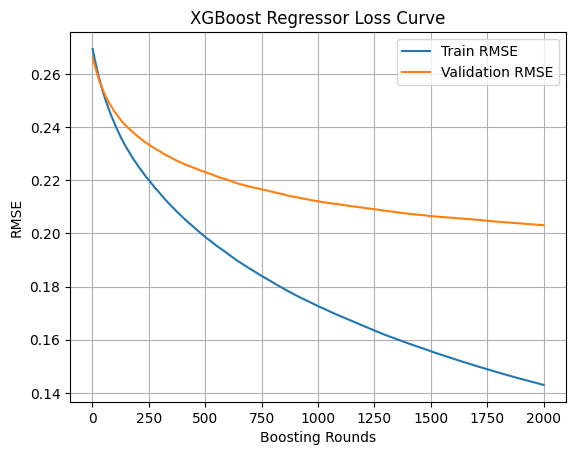

In [13]:
import matplotlib.pyplot as plt

results = xgb_model.evals_result()
epochs = range(1, len(results['validation_0']['rmse']) + 1)

fig, ax = plt.subplots()
ax.plot(epochs, results['validation_0']['rmse'], label='Train RMSE')
ax.plot(epochs, results['validation_1']['rmse'], label='Validation RMSE')
ax.legend()

plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Regressor Loss Curve')
plt.grid(True)
plt.show()

## Anti-Overfitting Improvements for LightGBM

The current LightGBM model is overfitting. Use these improved parameters:


In [14]:
import lightgbm as lgb

# ANTI-OVERFITTING: Stronger regularization to reduce overfitting
# Replace the old LightGBM model with these improved parameters
lgb_model_improved = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.02,  # Reduced from 0.1 for more conservative learning
    num_leaves=15,  # Reduced from 31 (default) - fewer leaves = simpler trees
    max_depth=3,  # Limit tree depth to prevent overfitting
    min_child_samples=20,  # Minimum samples per leaf (higher = more conservative)
    subsample=0.7,  # Row subsampling for more randomness
    colsample_bytree=0.7,  # Feature subsampling for more randomness
    reg_alpha=1.0,  # L1 regularization
    reg_lambda=5.0,  # L2 regularization (stronger)
    min_split_gain=0.1,  # Minimum gain for split (prevents unnecessary splits)
    random_state=42
)

# Use validation set for early stopping (not test set)
eval_set = [(X_train, y_train), (X_val, y_val)]

lgb_model_improved.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", callbacks=[lgb.early_stopping(stopping_rounds=50)])

# Evaluate improved model
y_pred_lgb_improved = lgb_model_improved.predict(X_test)
print(f"Improved LightGBM Test R²: {r2_score(y_test, y_pred_lgb_improved):.4f}")
print(f"Improved LightGBM Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lgb_improved)):.4f}")

# Compare train vs test to check overfitting
y_train_pred_improved = lgb_model_improved.predict(X_train)
print(f"\nTrain R²: {r2_score(y_train, y_train_pred_improved):.4f}")
print(f"Test R²:  {r2_score(y_test, y_pred_lgb_improved):.4f}")
print(f"Overfitting gap: {r2_score(y_train, y_train_pred_improved) - r2_score(y_test, y_pred_lgb_improved):.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 336198
[LightGBM] [Info] Number of data points in the train set: 7024, number of used features: 1536
[LightGBM] [Info] Start training from score 0.487347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [15]:
y_train_pred = xgb_model.predict(X_train)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test  R²:", r2_score(y_test, y_pred_xgb))

Train R²: 0.7194658517837524
Test  R²: 0.44954514503479004


In [16]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.1)

# Use validation set for early stopping (not test set)
eval_set = [(X_train, y_train), (X_val, y_val)]

lgb_model.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", callbacks=[lgb.early_stopping(stopping_rounds=50)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 336198
[LightGBM] [Info] Number of data points in the train set: 7024, number of used features: 1536
[LightGBM] [Info] Start training from score 0.487347
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[922]	training's rmse: 0.0152807	training's l2: 0.000233498	valid_1's rmse: 0.190909	valid_1's l2: 0.0364461


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [17]:
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate on test set (held out until now)
y_pred_lgb = lgb_model.predict(X_test)
print(f"Test Set - R Squared: {r2_score(y_test, y_pred_lgb):.3f}")
print(f"Test Set - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lgb)):.3f}")

Test Set - R Squared: 0.508
Test Set - RMSE: 0.189


In [18]:
y_train_pred_lgb = lgb_model.predict(X_train)

print("Train R²:", r2_score(y_train, y_train_pred_lgb))
print("Test  R²:", r2_score(y_test, y_pred_lgb))

Train R²: 0.9967955518809798
Test  R²: 0.5075066380667732


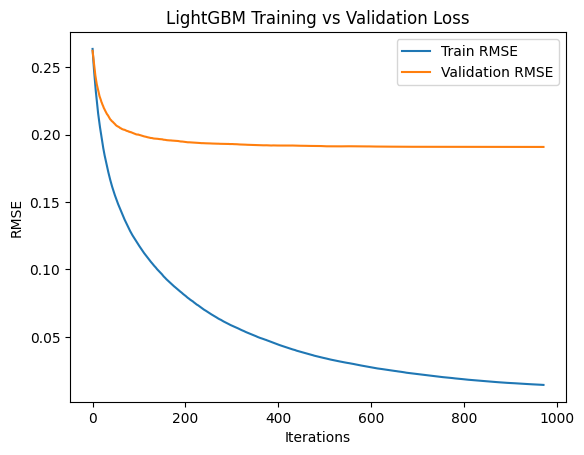

In [19]:
import matplotlib.pyplot as plt

results_lgb = lgb_model.evals_result_

train_rmse = results_lgb['training']['rmse']
val_rmse = results_lgb['valid_1']['rmse']

plt.plot(train_rmse, label="Train RMSE")
plt.plot(val_rmse, label="Validation RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("LightGBM Training vs Validation Loss")
plt.legend()
plt.show()

In [20]:
# LightGBM Validation and Test Set Evaluation
print("\n" + "="*50)
print("=== LightGBM Validation Set Results ===")
print("="*50)

y_val_pred_lgb = lgb_model.predict(X_val)

# Ensure shapes are 1-D arrays
y_val_true_lgb = np.ravel(y_val)
y_val_pred_lgb = np.ravel(y_val_pred_lgb)

# Metrics on validation
r2_val_lgb  = r2_score(y_val_true_lgb, y_val_pred_lgb)
mae_val_lgb = mean_absolute_error(y_val_true_lgb, y_val_pred_lgb)
rmse_val_lgb = np.sqrt(mean_squared_error(y_val_true_lgb, y_val_pred_lgb))

print(f"Samples: {len(y_val_true_lgb)}")
print(f"R²   : {r2_val_lgb:.4f}")
print(f"MAE  : {mae_val_lgb:.4f}")
print(f"RMSE : {rmse_val_lgb:.4f}")

# Summary comparison for LightGBM
print("\n" + "="*50)
print("LightGBM: Train/Val/Test Comparison")
print("="*50)

# Get train predictions for comparison
y_train_pred_lgb = lgb_model.predict(X_train)
r2_train_lgb = r2_score(y_train, y_train_pred_lgb)
mae_train_lgb = mean_absolute_error(y_train, y_train_pred_lgb)
rmse_train_lgb = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))

# Test set metrics (already computed)
r2_test_lgb = r2_score(y_test, y_pred_lgb)
mae_test_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_test_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

comparison_df_lgb = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Samples": [len(y_train), len(y_val_true_lgb), len(y_test)],
    "R²": [r2_train_lgb, r2_val_lgb, r2_test_lgb],
    "MAE": [mae_train_lgb, mae_val_lgb, mae_test_lgb],
    "RMSE": [rmse_train_lgb, rmse_val_lgb, rmse_test_lgb]
})
print(comparison_df_lgb.to_string(index=False))



=== LightGBM Validation Set Results ===
Samples: 2341
R²   : 0.4866
MAE  : 0.1441
RMSE : 0.1909

LightGBM: Train/Val/Test Comparison
       Set  Samples       R²      MAE     RMSE
     Train     7024 0.996796 0.007892 0.015281
Validation     2341 0.486620 0.144085 0.190909
      Test     2342 0.507507 0.141948 0.189252


=== XGBoost Test Set Results ===
Samples: 2342
R²   : 0.4495
MAE  : 0.1585
RMSE : 0.2001
Predictions saved to `models/xgb_predictions.csv`
Model saved to `models/xgb_res3.pkl`


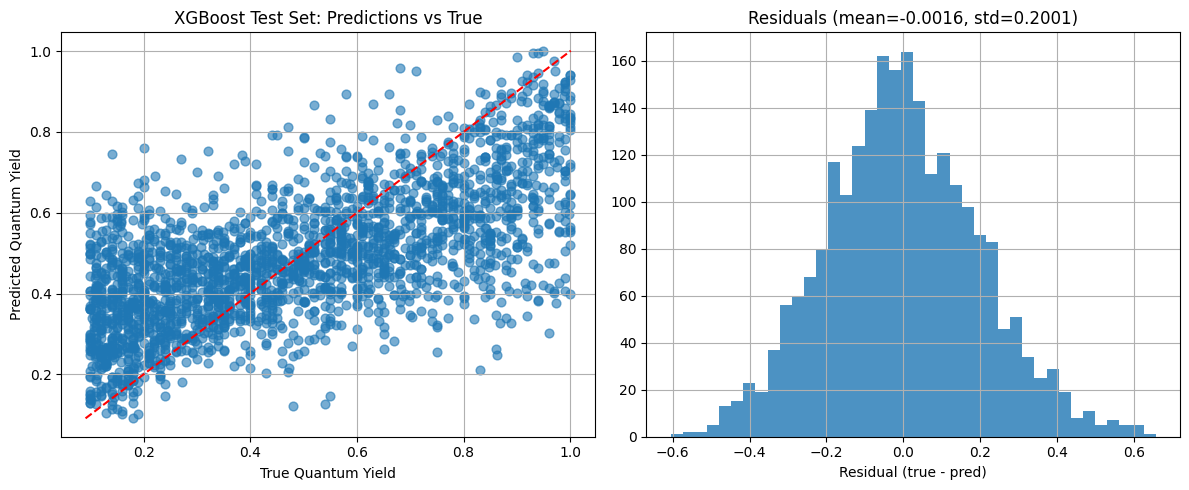

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import os

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Ensure shapes are 1-D arrays
y_true = np.ravel(y_test)
y_pred = np.ravel(y_pred)

# Metrics
r2  = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("=== XGBoost Test Set Results ===")
print(f"Samples: {len(y_true)}")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

# Save predictions (optional)
os.makedirs("models", exist_ok=True)
pred_df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
pred_df.to_csv("models/xgb_predictions.csv", index=False)
print("Predictions saved to `models/xgb_predictions.csv`")

# Save model (optional)
joblib.dump(xgb_model, "models/xgb_res3.pkl")
print("Model saved to `models/xgb_res3.pkl`")

# Plots: parity and residuals
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_true, y_pred, alpha=0.6, s=40)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("XGBoost Test Set: Predictions vs True")
plt.grid(True)

plt.subplot(1,2,2)
residuals = y_true - y_pred
plt.hist(residuals, bins=40, alpha=0.8)
plt.xlabel("Residual (true - pred)")
plt.title(f"Residuals (mean={residuals.mean():.4f}, std={residuals.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()

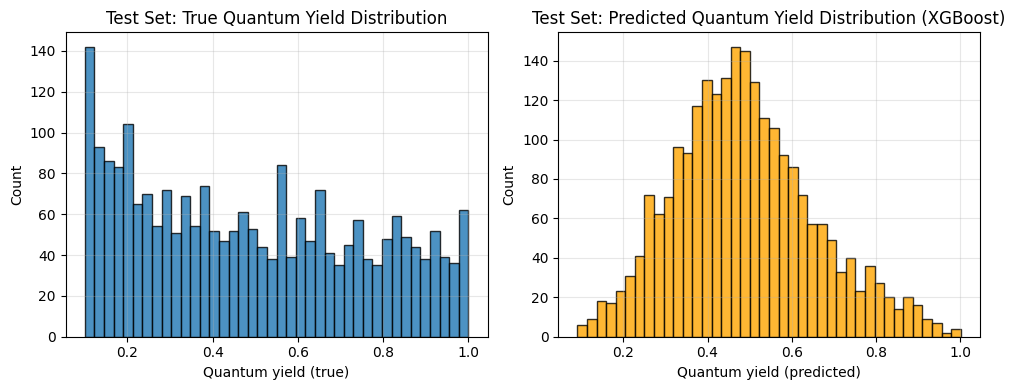

In [22]:
# Histograms of quantum yield after modeling (test set)
plt.figure(figsize=(10,4))

# True distribution on test set
plt.subplot(1,2,1)
plt.hist(y_true, bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield (true)")
plt.ylabel("Count")
plt.title("Test Set: True Quantum Yield Distribution")
plt.grid(True, alpha=0.3)

# Predicted distribution on test set (XGBoost)
plt.subplot(1,2,2)
plt.hist(y_pred, bins=40, alpha=0.8, edgecolor="black", color="orange")
plt.xlabel("Quantum yield (predicted)")
plt.ylabel("Count")
plt.title("Test Set: Predicted Quantum Yield Distribution (XGBoost)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



=== XGBoost Validation Set Results ===
Samples: 2341
R²   : 0.4189
MAE  : 0.1604
RMSE : 0.2031


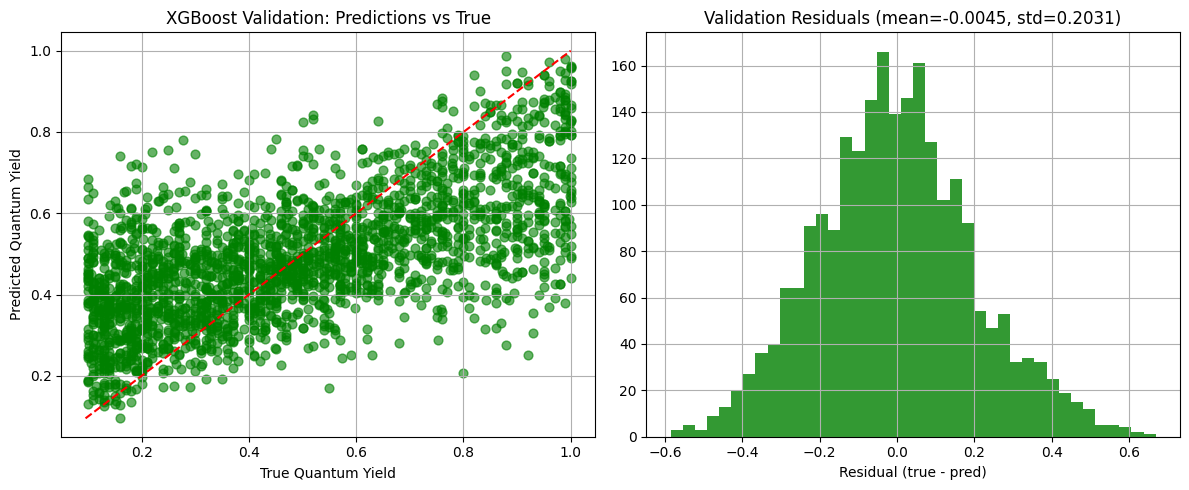


XGBoost: Train/Val/Test Comparison
       Set  Samples       R²      MAE     RMSE
     Train     7024 0.719466 0.112793 0.142974
Validation     2341 0.418909 0.160389 0.203108
      Test     2342 0.449545 0.158486 0.200079


In [23]:
# Validation Set Evaluation
print("\n" + "="*50)
print("=== XGBoost Validation Set Results ===")
print("="*50)

y_val_pred = xgb_model.predict(X_val)

# Ensure shapes are 1-D arrays
y_val_true = np.ravel(y_val)
y_val_pred = np.ravel(y_val_pred)

# Metrics on validation
r2_val  = r2_score(y_val_true, y_val_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

print(f"Samples: {len(y_val_true)}")
print(f"R²   : {r2_val:.4f}")
print(f"MAE  : {mae_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")

# Plots: validation parity and residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.6, s=40, color='green')
mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("XGBoost Validation: Predictions vs True")
plt.grid(True)

plt.subplot(1, 2, 2)
residuals_val = y_val_true - y_val_pred
plt.hist(residuals_val, bins=40, alpha=0.8, color='green')
plt.xlabel("Residual (true - pred)")
plt.title(f"Validation Residuals (mean={residuals_val.mean():.4f}, std={residuals_val.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "="*50)
print("XGBoost: Train/Val/Test Comparison")
print("="*50)

# Get train predictions for comparison
y_train_pred = xgb_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

comparison_df = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Samples": [len(y_train), len(y_val_true), len(y_true)],
    "R²": [r2_train, r2_val, r2],
    "MAE": [mae_train, mae_val, mae],
    "RMSE": [rmse_train, rmse_val, rmse]
})
print(comparison_df.to_string(index=False))